# ASTER Example
Adapted from the Ames Stereo Pipeline [documentation](https://stereopipeline.readthedocs.io/en/latest/examples.html?highlight=aster#aster-images)

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import requests
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
import asp_binder_utils as asp_utils

In [5]:
print(dask.__version__)

2023.5.0


In [6]:
#dask.config.config

## Universal settings

In [7]:
verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
#verbose = True # will print all the logs printed by ASP
output_res = 30 # m resolution for output DEM
#tsrs = '+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection of output DEM, orthoimages
tsrs = 'EPSG:32610' # projection of output DEM, orthoimages
map_res = 15 # m  resolution for orthorectified input stereo pair

## Preprocessing 0: Data Download

- ASTER L1A data can be ordered from NASA EarthDATA, from https://search.earthdata.nasa.gov/search
- Please select the GeoTiff dilevery before placing the order
- You will get an email when the order is ready, download the zip file.
- You can upload the dataset (zip_file) directly on the binder instance using the file viewer tab on your left
- For the purpose of this tutorial, we have downloaded and staged a sample dataset on zenodo, which can be accessed [here](https://zenodo.org/record/7972223#.ZG_qwdLMJhF)
- The dataset is a stereo pair over Mt. Rainier stratovolcano in Washington state

In [8]:
#ASTER Sample has been staged on Zenodo:
#https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1
zenodo_url = 'https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1'
fn = 'aster.zip'
if os.path.exists(fn):
    print(f"file {fn} already downloaded")
else:
    response = requests.get(zenodo_url)
    #Check for 200
    if response.ok:
        print ('OK!')
    else:
        print ('Query failed')
        sys.exit()
    #Write to disk
    open(fn, 'wb').write(response.content)
    print(f"file {fn} saved")

OK!
file aster.zip saved


In [9]:
aster_top_dir = 'aster_example'
with zipfile.ZipFile(fn, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(aster_top_dir)

## Preprocessing 1: Create left and right image and assosciated camera models (RPC and rigorous)

- `aster2asp` command takes in the unzipped ASTER image directory and produces 4 files
- Left and right image pairs (Band 3N and Band 3B)
- Two .xml files containing camera information for the left and right image
- The .xml files have both rigrous and RPC camera information

In [10]:
aster2asp = find_executable('aster2asp')
outfolder = 'aster_example_asp/out'
aster2asp_call = f'{aster2asp} {aster_top_dir} -o {outfolder}'

In [11]:
if verbose:
    ! $aster2asp_call
else:
    asp_utils.run_bash_command(aster2asp_call)

/srv/StereoPipeline/bin/aster2asp aster_example -o aster_example_asp/out
	--> Setting number of processing threads to: 4

Creating output directory: "aster_example_asp".
Writing: aster_example_asp/out-Band3N.xml
Writing: aster_example_asp/out-Band3B.xml
Writing: aster_example_asp/out-Band3N.tif
        -->: [*******************************************************] Complete!
Writing: aster_example_asp/out-Band3B.tif
        -->: [*******************************************************] Complete!


Child returned 0


## 3. Stereo Reconstruction and DEM Generation
- ASP can process an ASTER stereo pair using different modes, with customizable flags in each mode
- We give options for the 3 main modes, users can tweak the flags to see how it goes for them

### 3.1. Process with RPC camera
- First mode uses `RPC` camera for stereo triangulation and processing
- RPC is a set of polynomial function which is used to approximate actual camera sensor information
- This is the fastest mode to run, as the calculations required during stereo triangulation is minimal
- But as with any approximation, it is less accurate than the actual rigrous camera model

In [12]:
stereo = find_executable('stereo')
session = 'rpc'
stereo_algorithm = 'asp_bm'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_rpc/run'
stereo_call = f'{stereo} -t {session} --stereo-algorithm {stereo_algorithm}  --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
if verbose:
    ! stereo_call
else:
    asp_utils.run_bash_command(stereo_call)

/srv/StereoPipeline/bin/stereo -t rpc --stereo-algorithm asp_bm  --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_rpc/run



[ 2023-Sep-24 22:51:15 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: stereo_rpc/run-log-stereo_pprc-09-24-2251-3124.txt
Using session: rpc
Loading camera model: aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml
Loading camera model: aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml
Distance between camera centers in meters: 45145.8.
Using image files:  aster_example_asp/out-Band3N.tif, aster_example_asp/out-Band3B.tif
Using camera files: aster_example_asp/out-Band3N.xml, aster_example_asp/out-Band3B.xml
Computing statistics for left
Using downsample scale: 5
          stats:  [**************************************************] Complete!
	    Writing stats file: stereo_rpc/run-out-Band3N-stats.tif
	    left: [ lo: 13.1504 hi: 220.482 mean: 84.9501 std_dev: 32.1303 ]
Left image stats time: 0.61414

Child returned 0


In [13]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
if verbose:
    ! $point2dem_call
else:
    asp_utils.run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_rpc/run-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_rpc/run-PC.tif
	--> Setting number of processing threads to: 4
Writing log info to: stereo_rpc/run-log-point2dem-09-24-2257-6416.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 15051109 positive triangulation errors.
Error percentiles: Q1 (25%): 13.3017, Q2 (50%): 20.7351, Q3 (75%): 33.2544.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 99.7631 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2498,2372) px.
Writing: stereo_rpc/run-DEM.tif
DEM: [***********************************************

Child returned 0


In [14]:
stereo_dir = 'stereo_rpc/run' 

Found files stereo_rpc/run-L.tif
 stereo_rpc/run-R.tif
 stereo_rpc/run-F.tif
 stereo_rpc/run-IntersectionErr.tif
 stereo_rpc/run-DEM.tif



/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


[0.29919421 0.75468693]
[  39.64917969 2316.17378906]
<class 'numpy.ma.core.MaskedArray'>


/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


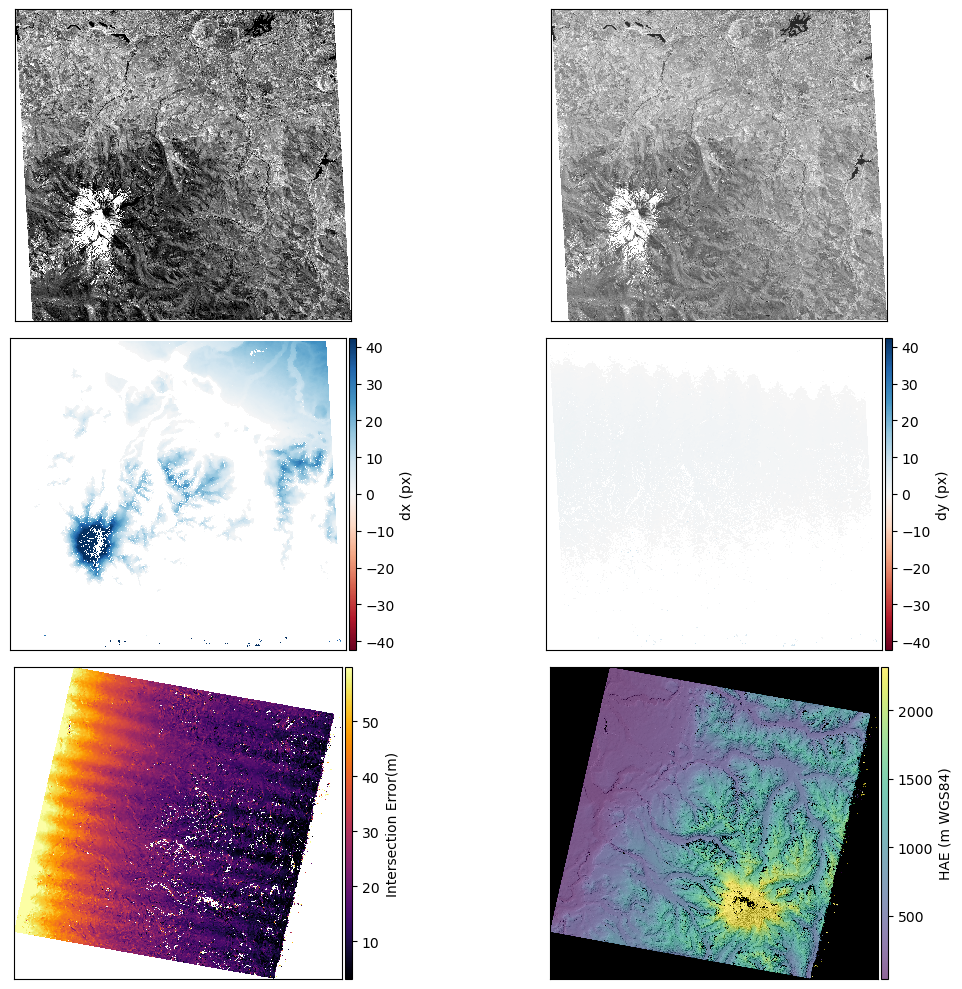

In [15]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

- The first two images are the left and right stereo pairs
- Notice they might seem to be flipped ! This is because they are aligned along the affine epipolar line by `stereo_pprc`, so the ASP's matching algorithms search in the effective x direction only 
- The second row are the filtered sub-pixel disparity maps (pixel offsets in the right image corresponding to left image, you can see that most of the disparity is in the x disparity only (left), the y disparity is almost 0 (due to the initial alignment).
- The third row contains the ray intersection error map and DEM overlaid on the corresponding hillshade.
- In general, intersection error used to evaluate camera pointing accuracy, lower error: self-consistent camera.

### 3.2. Process with ASTER Rigrous Camera Model

- The second mode uses ASTER Rigrous camera model
- This computation is slower but more accurate, the actual spacecraft attitude and ephermis data is used during triangulation step.

In [16]:
stereo = find_executable('stereo')
session = 'aster'
stereo_algorithm = 'asp_bm'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_aster_session/run'
stereo_call  = f'{stereo} -t {session} --stereo-algorithm {stereo_algorithm} --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
if verbose:
    ! stereo_call
else:
    asp_utils.run_bash_command(stereo_call)

/srv/StereoPipeline/bin/stereo -t aster --stereo-algorithm asp_bm --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session/run



[ 2023-Sep-24 22:58:01 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: stereo_aster_session/run-log-stereo_pprc-09-24-2258-6896.txt
Using session: aster
Loading camera model: aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml
Loading camera model: aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml
Distance between camera centers in meters: 410534.
Using image files:  aster_example_asp/out-Band3N.tif, aster_example_asp/out-Band3B.tif
Using camera files: aster_example_asp/out-Band3N.xml, aster_example_asp/out-Band3B.xml
Computing statistics for left
Using downsample scale: 5
          stats:  [**************************************************] Complete!
	    Writing stats file: stereo_aster_session/run-out-Band3N-stats.tif
	    left: [ lo: 13.1504 hi: 220.482 mean: 84.9501 std_dev: 32.1303 ]
Left imag

Child returned 0


In [17]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
if verbose:
    ! $point2dem_call
else:
    asp_utils.run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session/run-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_aster_session/run-PC.tif
	--> Setting number of processing threads to: 4
Writing log info to: stereo_aster_session/run-log-point2dem-09-24-2300-8732.txt
Statistics: [************.................................................] 21%

Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 15051181 positive triangulation errors.
Error percentiles: Q1 (25%): 24.7856, Q2 (50%): 28.0661, Q3 (75%): 30.982.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 92.9461 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2498,2371) px.
Writing: stereo_aster_session/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 69.0454%
Writing: stereo_aster_session/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!
DEM saved at stereo_aster_session/run-DEM.tif


Child returned 0


Found files stereo_aster_session/run-L.tif
 stereo_aster_session/run-R.tif
 stereo_aster_session/run-F.tif
 stereo_aster_session/run-IntersectionErr.tif
 stereo_aster_session/run-DEM.tif



[0.29919421 0.75468693]
[  83.49773437 2307.87757813]
<class 'numpy.ma.core.MaskedArray'>


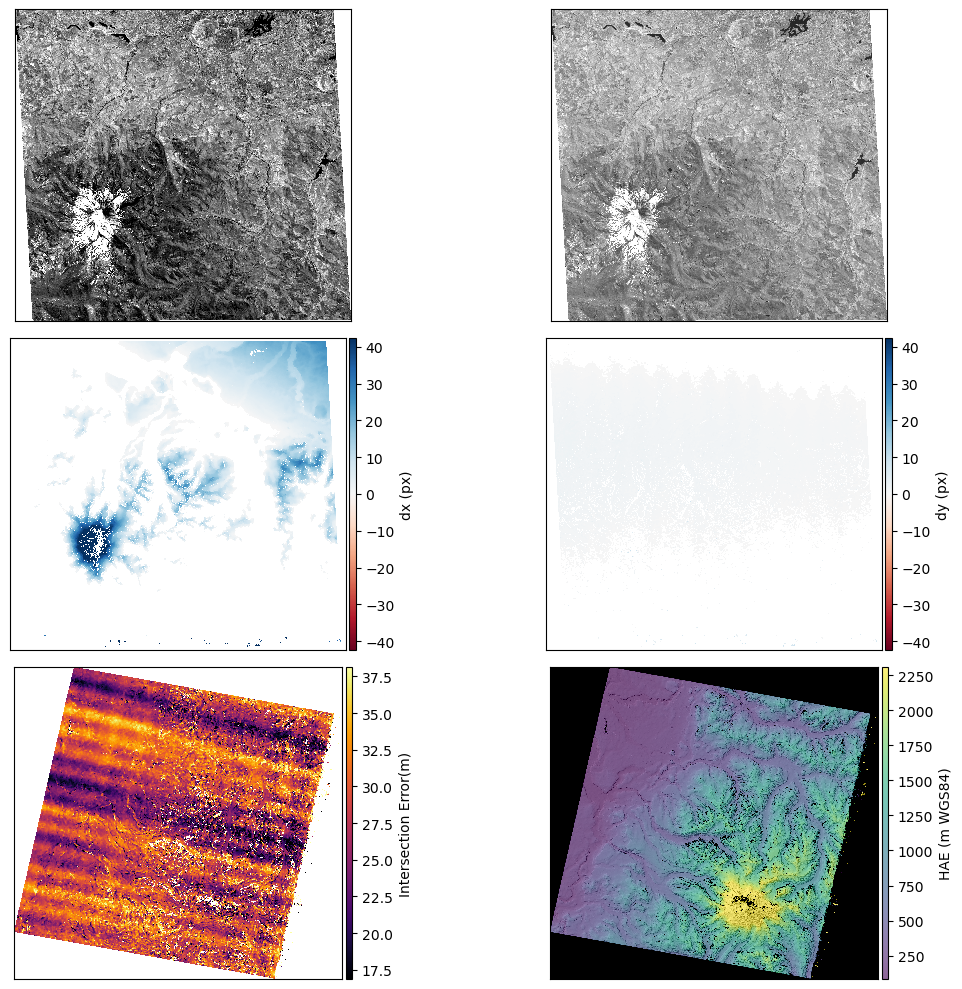

In [18]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

### 3.3 Use Orthorectified stereo inputs and ASTER camera model

- ASP can use orthorectified stereo input images
- Orthorectification helps in removing terrain disparity, helpful over steep areas (like the failed correlation over the Mt. Rainier volcano top. (see DEM above))
- When the point cloud triangulation occurs, the orthorectification is undone using the camera information and DEM.
- Here we will programmetically fetch SRTM DEM (GL1 Ellipsoidal) using the [opentopography api](https://portal.opentopography.org/apidocs/#/operations/Public) 
- The user will need to provide their opentopography api key which can be fetched by creating an account at [opentopography](https://opentopography.org/login)
- Input left and right image will be orthorectified using the downloaded SRTM DEM.
- The `stereo` and `point2dem` calls will then be evoked as usual.

#### Extent determination for dowmloading DEM from previous stereo output 

In [19]:
stereo_dir  = 'stereo_rpc/run'
dem_file = glob.glob(stereo_dir+'*-DEM.tif')[0]
# get aoi extent in geographic coordinates
aoi_extent = asp_utils.subsetBBox(dem_file,'EPSG:4326')
#in_crs = rasterio.open(dem_file).crs

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/workspaces/asp-binder-demo/asp_binder_utils.py:108: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  [Right,

In [20]:
opentopo_api_key = '' #paste your open topography api key within the quotes
reference_srtm = asp_utils.get_dem('SRTMGL1_E',aoi_extent,apikey=opentopo_api_key,proj=tsrs)
reference_srtm

https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-122.3493062657848&south=46.711450150858276&east=-121.34951915229212&north=47.34176397799961&outputFormat=GTiff&API_Key=demoapikeyot2022


OK!
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs 'EPSG:32610' SRTMGL1_E.tif SRTMGL1_E_proj.tif
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs 'EPSG:32610' SRTMGL1_E.tif SRTMGL1_E_proj.tif
Creating output file that is 2566P x 2372L.
Processing SRTMGL1_E.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image SRTMGL1_E.tif.
Copying nodata values from source SRTMGL1_E.tif to destination SRTMGL1_E_proj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Child returned 0


'SRTMGL1_E_proj.tif'

- We will now orthorectify the left and right stereo images using ASP's `mapproject` call and the adjusted SRTM DEM
- We will use the `rpc` camera for orthorectification (it is faster), while use the `rigrous ASTER` camera during triangulation, as it is more accurate.

In [21]:
mapproject = find_executable('mapproject')
l_map = os.path.splitext(l_img)[0]+'_map_utm.tif'
r_map = os.path.splitext(r_img)[0]+'_map_utm.tif'
mapproject_left_img_call = f"{mapproject} -t rpc --tr {map_res} --t_srs '{tsrs}' {reference_srtm} {l_img} {l_img_xml} {l_map}"
mapproject_right_img_call = f"{mapproject} -t rpc --tr {map_res} --t_srs '{tsrs}' {reference_srtm} {r_img} {r_img_xml} {r_map}"
if verbose:
    ! $mapproject_left_img_call
    ! $mapproject_right_img_call
else:
    asp_utils.run_bash_command(mapproject_left_img_call)
    asp_utils.run_bash_command(mapproject_right_img_call)

/srv/StereoPipeline/bin/mapproject -t rpc --tr 15 --t_srs 'EPSG:32610' SRTMGL1_E_proj.tif aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3N_map_utm.tif
mapproject_single --query-projection SRTMGL1_E_proj.tif aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3N_map_utm.tif -t rpc --tr 15 --t_srs EPSG:32610
	--> Setting number of processing threads to: 4
Using session: rpc
Loading camera model: aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml
Computed image to DEM bbox: (Origin: (549673, 5.17403e+06) width: 75203.4 height: 69520.9)
Output pixel size: 15
Projected space bounding box: (Origin: (549630, 5174010) width: 75300 height: 69540)
Image box: (Origin: (0, 0) width: 5021 height: 4637)
Output image size:
(width: 5021 height: 4637)
Query finished, exiting mapproject tool.

Output image size is 5021 by 4637 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /workspace

Child returned 0


mapproject_single --query-projection SRTMGL1_E_proj.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml aster_example_asp/out-Band3B_map_utm.tif -t rpc --tr 15 --t_srs EPSG:32610
	--> Setting number of processing threads to: 4
Using session: rpc
Loading camera model: aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml
Computed image to DEM bbox: (Origin: (549313, 5.17363e+06) width: 76032.1 height: 70663.9)
Output pixel size: 15
Projected space bounding box: (Origin: (549300, 5173530) width: 76050 height: 70770)
Image box: (Origin: (0, 0) width: 5071 height: 4719)
Output image size:
(width: 5071 height: 4719)
Query finished, exiting mapproject tool.

Output image size is 5071 by 4719 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /workspaces/asp-binder-demo -u --env PATH --env PYTHONPATH --env ISISROOT --env ASP_LIBRARY_PATH --env ISISDATA -a aster_example_asp/out-Band3B_map_utm_tif_tiles/argumentList.txt -P 1 --colsep \t /srv/Stereo

Child returned 0


- Now we can use the mapprojected image to rerun Stereo command
- This makes the process run faster during correlation stage, as the correlator's work in finding matches is reduced due to the smaller search range.
- Mapprojection improves correlation results in featureless or high sloped areas, like the snow-covered mountain tops

- The stereo call remains the same, we just need to update left and right image with their orthorectified ones, and provide a DEM after specifying the output directory, so that it can be used during triangulation to undo mapprojection

In [22]:
stereo = find_executable('stereo')
session = 'astermaprpc'
stereo_algorithm = 'asp_bm'
spm = 1 
stereo_dir  = 'stereo_aster_session_mapprojected/run'
stereo_call = f'{stereo} -t {session} --skip-rough-homography --stereo-algorithm {stereo_algorithm} --subpixel-mode {spm} {l_map} {r_map} {l_img_xml} {r_img_xml} {stereo_dir} {reference_srtm}'
if  verbose:
    ! $stereo_call
else:
    asp_utils.run_bash_command(stereo_call)

/srv/StereoPipeline/bin/stereo -t astermaprpc --skip-rough-homography --stereo-algorithm asp_bm --subpixel-mode 1 aster_example_asp/out-Band3N_map_utm.tif aster_example_asp/out-Band3B_map_utm.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session_mapprojected/run SRTMGL1_E_proj.tif

[ 2023-Sep-24 23:04:33 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: stereo_aster_session_mapprojected/run-log-stereo_pprc-09-24-2304-10966.txt
Using session: astermaprpc
Loading RPC cameras used in mapprojection.
Mapprojected images bundle adjustment prefix: ""
Left camera file used in mapprojection: aster_example_asp/out-Band3N.xml
Right camera file used in mapprojection: aster_example_asp/out-Band3B.xml
Loading camera model: aster_example_asp/out-Band3N_map_utm.tif aster_example_asp/out-Band3N.xml
Loading camera

Child returned 0


In [23]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
if verbose:
    ! $point2dem_call
else:
    asp_utils.run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session_mapprojected/run-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_aster_session_mapprojected/run-PC.tif
	--> Setting number of processing threads to: 4
Writing log info to: stereo_aster_session_mapprojected/run-log-point2dem-09-24-2307-13434.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 16500533 positive triangulation errors.
Error percentiles: Q1 (25%): 25.4761, Q2 (50%): 28.3466, Q3 (75%): 30.4995.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 91.4986 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2471,2283) px.
Writing: stereo

Child returned 0


Found files stereo_aster_session_mapprojected/run-L.tif
 stereo_aster_session_mapprojected/run-R.tif
 stereo_aster_session_mapprojected/run-F.tif
 stereo_aster_session_mapprojected/run-IntersectionErr.tif
 stereo_aster_session_mapprojected/run-DEM.tif



[0.27935206 0.74298799]
[  86.76376953 2335.00029297]
<class 'numpy.ma.core.MaskedArray'>


/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


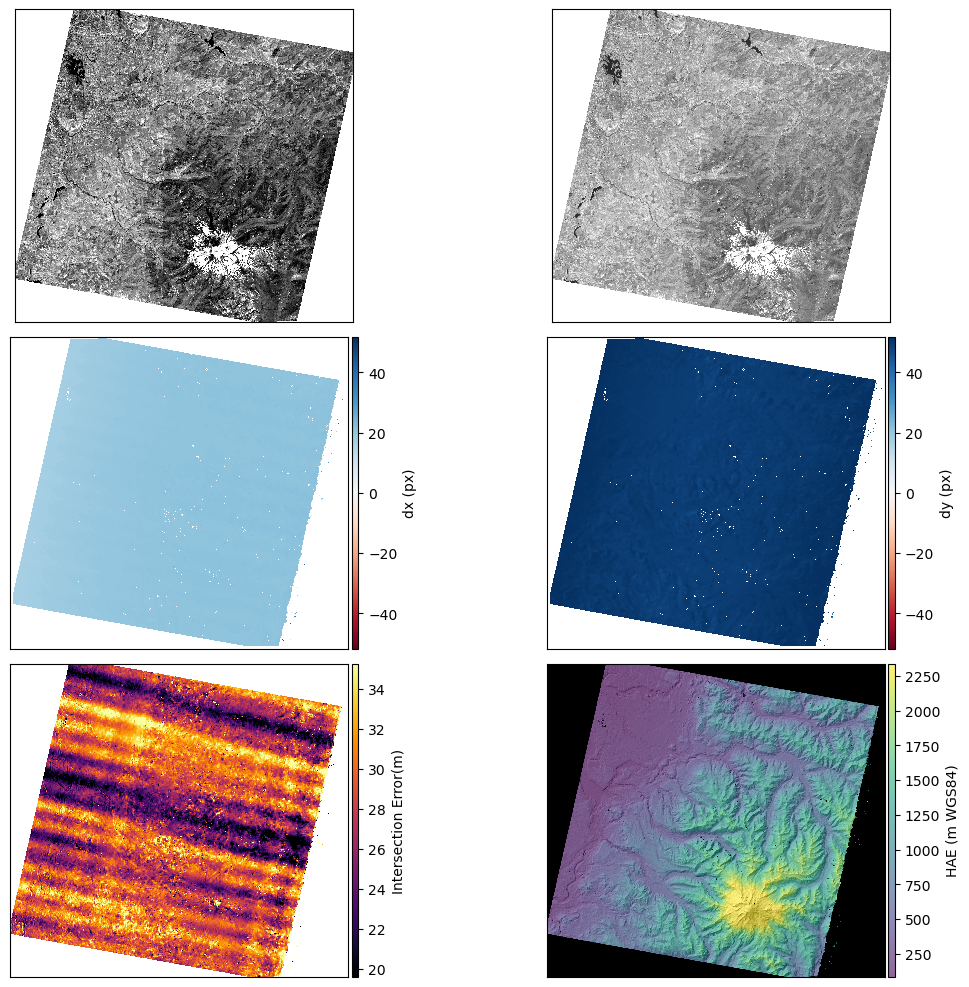

In [24]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

- Note the left and right images are oriented correctly (they are already orthorectified)
- The output DEM is complete over the volcano top